<a href="https://www.kaggle.com/code/sharanharsoor/ner-by-crf-and-deep-learning?scriptVersionId=124915193" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction : 

In this notebook, we will demonstrate the code for Named Entity Recognition with 2 techniques. 
NER is just text token classification. Token classification is a natural language understanding task in which a label is assigned to some tokens in a text.
1. NER with Conditional Random Field: Conditional Random Field (CRF) is a sequence labelling technique that can be used to perform  NER tagging. CRF is a type of probabilistic model that uses conditional probabilities to predict outcomes. In a regular ML algorithm, the joint probability of the observed and target variables is calculated and for CRF it's conditional probablity  P(A|B)  more can be found at [here](https://www.youtube.com/watch?v=rc3YDj5GiVM&t=981s) : <cr>
    
2. The second approach will be finding the NLP NER labels using TensorFlow, which will be using the code from the notebook [link](https://www.kaggle.com/code/naseralqaydeh/named-entity-recognition-ner-with-tensorflow).

# 0. imports and install

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

  Preparing metadata (setup.py) ... - done
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1896 sha256=223823e9b26465dc07c723721fab4aa2d37df5a3285d24a3316bd013e1fdad24
  Stored in directory: /root/.cache/pip/wheels/51/e5/3f/0f22610c13455d3da2fdaa5b890e2012114d0a3f07cd15f572
Successfully built pycrf
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.9/966.9 kB 29.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import random
import plotly.express as px
import spacy 
from collections import Counter
import tensorflow as tf
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from itertools import chain
import nltk
import sklearn
from collections import Counter
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
model = spacy.load("en_core_web_sm")
sns.set_style('darkgrid')

# 1. Need of NER

NER acronym is named entity recognition. Mostly the idea of NER is to give the detailed specifics of a proper noun. Say for example if googling "who is the CEO of Amazon". In this case, google search had to first recognise that the word "Amazon" is referring to an organisation and not a jungle, before displaying the information. Using the POS tag, in this case, would only give information that Amazon is a noun but this hardly says any information beyond. NER is the tag, that helps in knowing if a reference is a person, organisation, location, music album, movie, geopolitical entity etc. 

## 1.1 POS Tagging

In [3]:
processed_doc = model(u"Arun lives in India")

for token in processed_doc:
  print(token.text, " -- ", token.pos_)

Arun  --  NOUN
lives  --  VERB
in  --  ADP
India  --  PROPN


In this case POS have found both "Arun" and "India" as PROPN (Proper Noun), but they are not giving any info about the nouns as such. Let's see if NER helps in this case. 

In [4]:
for ent in processed_doc.ents:
    print(processed_doc)
    print(ent.text, " -- ", ent.start_char, " -- ", ent.end_char, " -- ", ent.label_)

Arun lives in India
India  --  14  --  19  --  GPE


In [5]:
# another example
processed_doc = model(u"Statue of Liberty is situated in New York, USA.")
for token in processed_doc:
  print(token.text, " -- ", token.pos_)

Statue  --  PROPN
of  --  ADP
Liberty  --  PROPN
is  --  AUX
situated  --  VERB
in  --  ADP
New  --  PROPN
York  --  PROPN
,  --  PUNCT
USA  --  PROPN
.  --  PUNCT


In [6]:
for ent in processed_doc.ents:
  print(ent.text, " -- ", ent.start_char, " -- ", ent.end_char, " -- ", ent.label_)

New York  --  33  --  41  --  GPE
USA  --  43  --  46  --  GPE


## Need of NER traning. 

In the above example although the "Statue of Liberty" is a named entity the pre-trained model from spicy has missed finding it. The reason is, the generalised model can't be trained on all the data, in such cases, it's important to have a set of data and a pre-labelled NER to train the model to predict. 
The usage of this can help in many fields. for eg, in medicine, a decision and corresponding treatment can be set as D and T in a sentence manually to train the model. The same model can be used for an unknown disease to find the near treatments available, this can help doctors to understand the previous treatments and narrow down the possible treatments required. 

Next, we will see a couple of methods on how a NER model can be created from an available dataset with NER tags.

# 2. Reading Data and processing

In [7]:
data_ner = pd.read_csv("../input/entity-annotated-corpus/ner.csv", encoding = "unicode_escape", error_bad_lines=False,  \
                       usecols=['sentence_idx', 'word', 'tag']
)
print(data_ner.shape)
data_ner.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


(1050796, 3)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


In [8]:
print(data_ner[data_ner['sentence_idx'] == 'prev-lemma'])

       sentence_idx           word              tag
281835   prev-lemma  prev-prev-iob  prev-prev-lemma


In [9]:
data_ner  = data_ner[data_ner['sentence_idx'] != 'prev-lemma'].dropna(subset=['sentence_idx']).reset_index(drop=True)
data_ner['sentence_idx'] = data_ner['sentence_idx'].apply(int)
data_ner['tag'] = data_ner['tag'].apply(lambda x: x if x == 'O' else x[2:])
print(data_ner.shape)
data_ner.head()

(1050794, 3)


,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


# 3. Understanding NER 

In [10]:
# in the below example, India is found as Geo polictical entities. this is how each sentance and tags are marked in the data as input sentances 
# and output labels.

def extract_entities(doc):
    entities = []
    if doc.ents:
        for ent in doc.ents:
            entity = {
                "text": ent.text,
                "start_char": ent.start_char,
                "end_char": ent.end_char,
                "label": ent.label_,
                "label_description": spacy.explain(ent.label_)
            }
            entities.append(entity)
    else:
        print("No named entities found.")
    return entities

doc = model(u'India is a great country.')
extract_entities (doc)

[{'text': 'India',
  'start_char': 0,
  'end_char': 5,
  'label': 'GPE',
  'label_description': 'Countries, cities, states'}]

# 4. EDA

In [11]:
print("Number of sentances      = {0}".format(data_ner['sentence_idx'].nunique()))
print("Number of unique words:  = {0}".format(len(list(set(data_ner["word"].values)))))
print("Number of unique tags :  = {0}".format(len(list(set(data_ner["tag"].values)))))
print("unique tags           :  = {0}".format((list(set(data_ner["tag"].values)))))

Number of sentances      = 35177
Number of unique words:  = 30172
Number of unique tags :  = 9
unique tags           :  = ['O', 'gpe', 'org', 'geo', 'eve', 'art', 'tim', 'per', 'nat']


In [12]:
fig = px.histogram(data_ner, x=data_ner['sentence_idx'].value_counts().values ,nbins=50)
fig.update_layout(
    title="Sentences",
    xaxis_title="Sentences with number of words",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

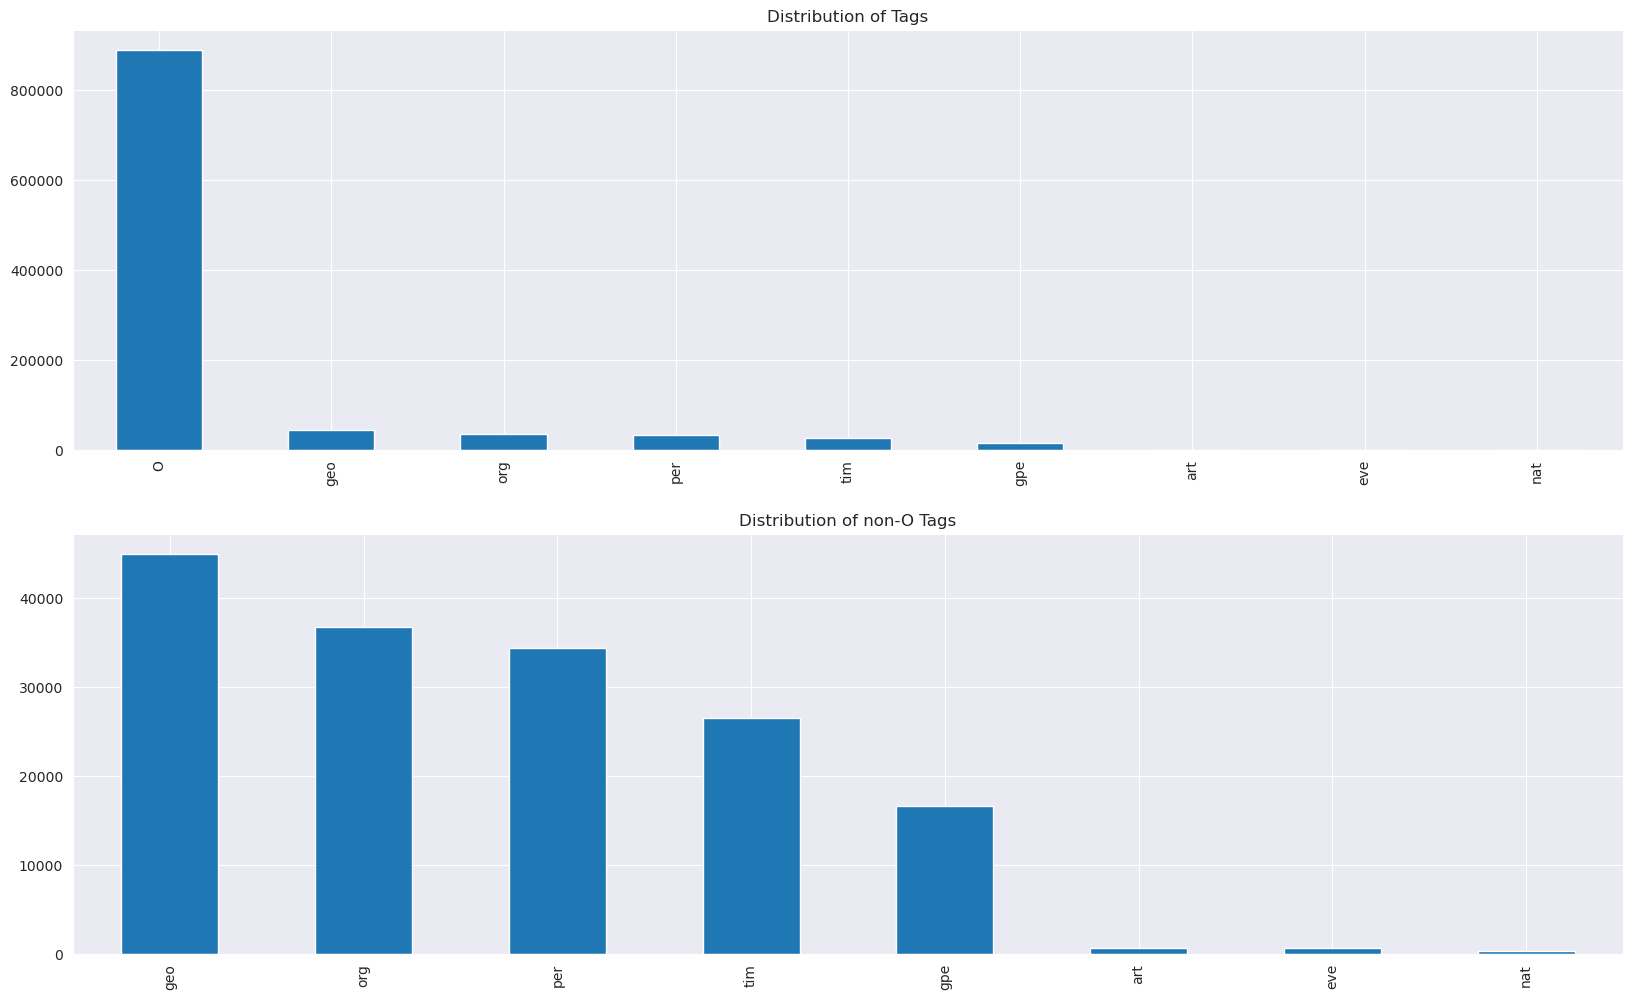

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
data_ner.tag.value_counts().plot.bar(ax=ax[0], title='Distribution of Tags')
data_ner[data_ner.tag != 'O'].tag.value_counts().plot.bar(ax=ax[1], title='Distribution of non-O Tags')
fig.show()

In [14]:
words = pd.DataFrame(data_ner.groupby('sentence_idx')['word'].apply(list))
tags = data_ner.groupby('sentence_idx')['tag'].apply(list)
words['tag'] = tags
words['sentence'] = words['word'].apply(lambda x: ' '.join(x))
words['tag_combine'] = words['tag'].apply(lambda x: ' '.join(x))
words = words.reset_index()
words.head()

,sentence_idx,word,tag,sentence,tag_combine
0,1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, geo, O, O, O, O, O, geo, O,...",Thousands of demonstrators have marched throug...,O O O O O O geo O O O O O geo O O O O O gpe O ...
1,2,"[Families, of, soldiers, killed, in, the, conf...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",Families of soldiers killed in the conflict jo...,O O O O O O O O O O O O O O O O O O per O O O ...
2,3,"[They, marched, from, the, Houses, of, Parliam...","[O, O, O, O, O, O, O, O, O, O, O, geo, geo, O,...",They marched from the Houses of Parliament to ...,O O O O O O O O O O O geo geo O O O O O O O O ...
3,4,"[Police, put, the, number, of, marchers, at, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","Police put the number of marchers at 10,000 wh...",O O O O O O O O O O O O O O O O O O O O O O O ...
4,5,"[The, protest, comes, on, the, eve, of, the, a...","[O, O, O, O, O, O, O, O, O, O, O, geo, O, O, o...",The protest comes on the eve of the annual con...,O O O O O O O O O O O geo O O org org O O O gp...


In [15]:
def num_words_tags (tags, data):
    
    """This functions takes the tags we want to count and the datafram 
    and return a dict where the key is the tag and the value is the frequency
    of that tag"""
    
    tags_count = {}
    
    for tag in tags:
        len_tag = len(data[data['tag'] == tag])
        tags_count[tag] = len_tag
    
    return tags_count

tags = data_ner["tag"].unique()
tags_count = num_words_tags(tags, data_ner)
tags_count

{'O': 889973,
 'geo': 44934,
 'gpe': 16621,
 'per': 34393,
 'org': 36721,
 'tim': 26491,
 'art': 714,
 'nat': 302,
 'eve': 645}

# 5. NER tagging by Conditional Random Field (CRF) 

In [16]:
## 5.1 preparing data for CRF

train_data, test_data, train_label, test_label = train_test_split(words['sentence'], words['tag_combine'], test_size=0.25, random_state=42)
train_data = train_data.tolist()
test_data = test_data.tolist()
train_label = train_label.tolist()
test_label = test_label.tolist()

In [17]:
print("Training Samples: \n")
for data in range(5):
  print("Sentence {0} : {1}".format(data+1,train_data[data]))
  print("Label    {0} : {1} \n".format(data+1,train_label[data]))

Training Samples: 

Sentence 1 : An Indian court has convicted two men , and acquitted one , on charges connected to a series of bombings 13 years ago that killed 257 people in Mumbai - formerly known as Bombay .
Label    1 : O gpe O O O O O O O O O O O O O O O O O O tim O O tim O O O O geo geo O O O geo O 

Sentence 2 : Bank experts say the downturn is likely to hit poor nations hard , even though financial markets in wealthy nations are stabilizing . Bank experts say the downturn is likely to hit poor nations hard , even though financial markets in wealthy nations are stabilizing .
Label    2 : org O O O O O O O O O O O O O O O O O O O O O O org O O O O O O O O O O O O O O O O O O O O O O 

Sentence 3 : Early Saturday , a slow-moving depression was reported to be about 1,000 kilometers west-southwest of the Cape Verde Islands .
Label    3 : O tim O O O O O O O O O O O O O O geo geo geo O 

Sentence 4 : The charges come 10 days after the U.S. military began an investigation into alleg

In [18]:
# define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos]
  ]

  #Use the previous word also while defining features
  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word.pos=' + pos_tags[pos-1]
  ])
  # Mark the begining and the end words of a sentence correctly in the form of features.
  else:
    features.append('BEG') # feature to track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features


In [19]:
# get features for a sentence.

def getFeaturesForOneSentence(sentence):
    
    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    
    for each_token in processed_sent:
        postags.append(each_token.pos_)
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags) for pos in range(len(sentence_list))]


In [20]:
# labels for a sentence.

def getLabelsInListForOneSentence(labels):
  return labels.split()

In [21]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_data[10]
print(example_sentence)
features = getFeaturesForOneSentence(example_sentence)
features[10]

Iranian demonstrators accused the British government of being an accomplice in Israel 's fight against Hezbollah .


['word.lower=in',
 'word[-3:]=in',
 'word[-2:]=in',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADP',
 'prev_word.lower=accomplice',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=NOUN']

In [22]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_data]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_data]
print(len(X_train))
print(len(X_test))

26382
8795


In [23]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_label]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_label]
print(len(Y_train))
print(len(Y_test))

26382
8795


In [24]:
ret = True
def remove_uneven_len(train_x, train_y):    
    for i in range(len(train_x)):
        if (len(train_x)-1 == i):
            return False, train_x, train_y
        elif(len(train_x[i]) != len(train_y[i])):
            del train_x[i]
            del train_y[i]
            print(i,len(train_x[i]), len(train_y[i]))
            return True, train_x, train_y
while(ret):
    ret, X_train, Y_train = remove_uneven_len(Y_train, Y_train)

In [25]:
# Build the CRF model.

crf = sklearn_crfsuite.CRF(max_iterations=1000)
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass
predictions = crf.predict(X_test)

In [26]:
Y_pred = crf.predict(X_test)

In [27]:
labels = list(crf.classes_)
labels

['O', 'gpe', 'tim', 'geo', 'org', 'per', 'nat', 'art', 'eve']

In [28]:
f1_scr = metrics.flat_f1_score(Y_test, Y_pred, average='weighted',labels=labels)
print("f1 score : ",round(f1_scr,4) )

f1 score :  0.7783


In [29]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

#print("Top likely transitions:")
def print_top_likely_transitions(trans_features):
  print_transitions(Counter(trans_features).most_common(10))

#print("\nTop unlikely transitions:")
def print_top_unlikely_transitions(trans_features):
  print_transitions(Counter(trans_features).most_common()[-10:])


In [30]:
print_top_likely_transitions(crf.transition_features_)

O      -> O       2.389218
eve    -> eve     1.621901
art    -> art     1.617888
per    -> per     1.380379
tim    -> O       1.175832
O      -> tim     1.022297
nat    -> nat     0.988160
O      -> nat     0.780098
nat    -> O       0.769200
tim    -> tim     0.758656


In [31]:
print_top_unlikely_transitions(crf.transition_features_)

org    -> gpe     -0.351736
art    -> per     -0.358602
art    -> org     -0.420694
geo    -> gpe     -0.437068
gpe    -> geo     -0.466643
org    -> per     -0.521755
geo    -> per     -0.592162
per    -> gpe     -0.729292
geo    -> org     -1.188773
org    -> geo     -1.246195


# 6. NER tagging by Deep Learning (Tensrflow)

In [32]:
spacy_data = []
for idx, row in words.iterrows():
    tokens = row['word']
    tags = row['tag']
    entities = [
        (len(' '.join(tokens[:i])) + 1, len(' '.join(tokens[:i])) + len(tokens[i]) + 1, tags[i]) 
        if i != 0 else
        (len(' '.join(tokens[:i])), len(' '.join(tokens[:i])) + len(tokens[i]), tags[i])
        for i in range(len(tags)) if tags[i] != 'O'
    ]
    data_tuple = (row['sentence'], {'entities': entities})
    spacy_data.append(data_tuple)
spacy_data[:5]    

[('Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
  {'entities': [(48, 54, 'geo'),
    (77, 81, 'geo'),
    (111, 118, 'gpe'),
    (194, 200, 'geo'),
    (223, 227, 'geo'),
    (257, 264, 'gpe')]}),
 ('Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . " Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "',
  {'entities': [(109, 113, 'per'), (274, 278, 'per')]}),
 ('They marched from the Houses of Parliament to a rally in Hyde Park . They marched from the Houses of Parliament to a rally in Hyde Park .',
  {'entities': [(57

In [33]:
def num_words_tags (tags, data):
    
    """This functions takes the tags we want to count and the datafram 
    and return a dict where the key is the tag and the value is the frequency
    of that tag"""
    
    tags_count = {}
    
    for tag in tags:
        len_tag = len(data[data['tag'] == tag])
        tags_count[tag] = len_tag
    
    return tags_count

tags = data_ner["tag"].unique()
tags_count = num_words_tags(tags, data_ner)
tags_count

{'O': 889973,
 'geo': 44934,
 'gpe': 16621,
 'per': 34393,
 'org': 36721,
 'tim': 26491,
 'art': 714,
 'nat': 302,
 'eve': 645}

In [34]:
X = list(words['sentence'])
Y = list(words['tag'])

In [35]:
from ast import literal_eval
Y_ready = []
for sen_tags in Y:
    Y_ready.append(literal_eval(str(sen_tags)))

In [36]:
# cutoff reviews after 110 words
maxlen = 110

# consider the top 36000 words in the dataset
max_words = 36000

# tokenize each sentence in the dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
print(tokenizer)

In [37]:
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

Found 24381 unique tokens.


In [38]:
ind2word = dict([(value, key) for (key, value) in word_index.items()])
word2id = word_index
id2word = {}
for key, value in word2id.items():
    id2word[value] = key

In [39]:
X_preprocessed = pad_sequences(sequences, maxlen=maxlen, padding='post')
X_preprocessed[0]

array([ 265,    3,  938,   13, 1994,  249,  457,    4,  512,    1,  122,
          2,   59,    6,  662,    1,  830,    3,  183,   91,   20,   12,
         52,  265,    3,  938,   13, 1994,  249,  457,    4,  512,    1,
        122,    2,   59,    6,  662,    1,  830,    3,  183,   91,   20,
         12,   52,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [40]:
tags2id = {}
for i, tag in enumerate(tags):
    tags2id[tag] = i
tags2id

{'O': 0,
 'geo': 1,
 'gpe': 2,
 'per': 3,
 'org': 4,
 'tim': 5,
 'art': 6,
 'nat': 7,
 'eve': 8}

In [41]:
id2tag = {}
for key, value in tags2id.items():
    id2tag[value] = key
id2tag

{0: 'O',
 1: 'geo',
 2: 'gpe',
 3: 'per',
 4: 'org',
 5: 'tim',
 6: 'art',
 7: 'nat',
 8: 'eve'}

In [42]:
def preprocess_tags(tags2id, Y_ready):
    
    Y_preprocessed = []
    maxlen = 110
    i = 0
    # for each target 
    for y in Y_ready:
        j = 0
        # place holder to store the new preprocessed tag list
        Y_place_holder = []
        
        # for each tag in rhe tag list 
        for tag in y:
            if(j >= 110):
                pass
            else:
                Y_place_holder.append(tags2id[tag])
            j +=1
        
        # find the lenght of the new preprocessed tag list 
        len_new_tag_list = len(Y_place_holder)
        # find the differance in length between the len of tag list and padded sentences
        num_O_to_add = maxlen - len_new_tag_list
        
        # add 'O's to padd the tag lists
        padded_tags = Y_place_holder + ([tags2id['O']] * num_O_to_add)
        Y_preprocessed.append(padded_tags)
        
    return Y_preprocessed

In [43]:
Y_preprocessed = preprocess_tags(tags2id, Y_ready)
print("The Lenght of training examples: {}".format(len(X_preprocessed)))
print("The Lenght of training targets: {}".format(len(Y_preprocessed)))

The Lenght of training examples: 35177
The Lenght of training targets: 35177


In [44]:
X_preprocessed = np.asarray(X_preprocessed)
Y_preprocessed = np.asarray(Y_preprocessed)

In [45]:
# 70% of the datat will be used for training 
training_samples = 0.7
# 15% of the datat will be used for validation 
validation_samples = 0.15
# 15% of the datat will be used for testing 
testing_samples = 0.15

In [46]:
indices = np.arange(len(Y_preprocessed))
np.random.seed(seed=555)
np.random.shuffle(indices)
X_preprocessed = X_preprocessed[indices]
Y_preprocessed = Y_preprocessed[indices]

X_train = X_preprocessed[: int(0.7 * len(X_preprocessed))]
print("Number of training examples: {}".format(len(X_train)))


X_val = X_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
print("Number of validation examples: {}".format(len(X_val)))


X_test = X_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]
print("Number of testing examples: {}".format(len(X_test)))


Y_train = Y_preprocessed[: int(0.7 * len(X_preprocessed))]
Y_val = Y_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
Y_test = Y_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]

print("Total number of examples after shuffling and splitting: {}".format(len(X_train) + len(X_val) + len(X_test)))

Number of training examples: 24623
Number of validation examples: 5277
Number of testing examples: 5277
Total number of examples after shuffling and splitting: 35177


In [47]:
X_train = X_train.reshape(-1, 1, 110)
X_val  = X_val.reshape(-1, 1, 110)
X_test = X_test.reshape(-1, 1, 110)
Y_train = Y_train.reshape(-1, 1, 110)
Y_val = Y_val.reshape(-1, 1, 110)
Y_test = Y_test.reshape(-1, 1, 110)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [48]:
embedding_dim = 300
maxlen = 110
max_words = 36000
num_tags = len(tags)

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_tags, activation='softmax'))
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 110, 300)          10800000  
                                                                 
 bidirectional (Bidirectiona  (None, 110, 200)         320800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 110, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 110, 9)           1809      
 ibuted)                                                         
                                                                 
Total params: 11,363,409
Trainable params: 11,363,409
Non-trainable params: 0
____________________________________________

In [49]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [50]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=3)

Epoch 1/3
24623/24623 [==============================] - 449s 18ms/step - loss: 0.0962 - accuracy: 0.9690 - val_loss: 0.0794 - val_accuracy: 0.9724
Epoch 2/3
24623/24623 [==============================] - 448s 18ms/step - loss: 0.0677 - accuracy: 0.9758 - val_loss: 0.0787 - val_accuracy: 0.9732
Epoch 3/3
24623/24623 [==============================] - 455s 18ms/step - loss: 0.0560 - accuracy: 0.9795 - val_loss: 0.0811 - val_accuracy: 0.9732


In [51]:
model.evaluate(test_dataset)

5277/5277 [==============================] - 36s 7ms/step - loss: 0.0801 - accuracy: 0.9732


[0.08014702796936035, 0.9731751680374146]

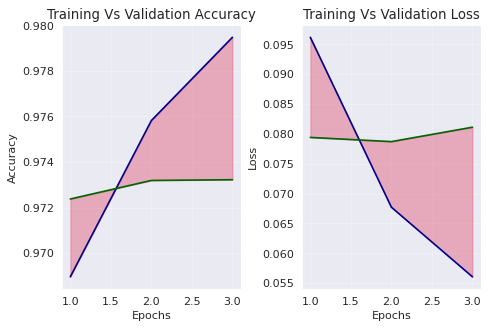

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 4), dpi=80)

ax[0].plot(epochs, acc, label = "Training Accuracy", color='darkblue')
ax[0].plot(epochs, val_acc, label = "Validation Accuracy", color='darkgreen')
ax[0].grid(alpha=0.3)
ax[0].title.set_text('Training Vs Validation Accuracy')
ax[0].fill_between(epochs, acc, val_acc, color='crimson', alpha=0.3)
plt.setp(ax[0], xlabel='Epochs')
plt.setp(ax[0], ylabel='Accuracy')


ax[1].plot(epochs, loss, label = "Training Loss", color='darkblue')
ax[1].plot(epochs, val_loss, label = "Validation Loss", color='darkgreen')
ax[1].grid(alpha=0.3)
ax[1].title.set_text('Training Vs Validation Loss')
ax[1].fill_between(epochs,loss, val_loss, color='crimson', alpha=0.3)
plt.setp(ax[1], xlabel='Epochs')
plt.setp(ax[1], ylabel='Loss')

plt.show()

In [53]:
def make_prediction(model, preprocessed_sentence, id2word, id2tag):
    
    #if preprocessed_sentence.shape() != (1, 110):
    preprocessed_sentence = preprocessed_sentence.reshape((1, 110))
     
    # return preprocessed sentence to its orginal form
    sentence = preprocessed_sentence[preprocessed_sentence > 0]
    word_list = []
    for word in list(sentence):
        word_list.append(id2word[word])
    orginal_sententce = ' '.join(word_list)
    
    len_orginal_sententce = len(word_list)
    
    # make prediction
    prediction = model.predict(preprocessed_sentence)
    prediction = np.argmax(prediction[0], axis=1)
    
    # return the prediction to its orginal form
    prediction = list(prediction)[ : len_orginal_sententce] 
    
    pred_tag_list = []
    for tag_id in prediction:
        pred_tag_list.append(id2tag[tag_id])
    
    return orginal_sententce,  pred_tag_list

In [54]:
orginal_sententce,  pred_tag_list = make_prediction(model=model,
                                                    preprocessed_sentence=X_test[403],
                                                    id2word=id2word,
                                                    id2tag=id2tag)

1/1 [==============================] - 1s 1s/step


In [55]:
print(orginal_sententce)

but several senior palestinian leaders are calling for a delay in the vote citing dire law and order conditions and israel 's refusal to permit voting in east jerusalem but several senior palestinian leaders are calling for a delay in the vote citing dire law and order conditions and israel 's refusal to permit voting in east jerusalem


In [56]:
print(pred_tag_list)

['O', 'O', 'O', 'gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


# END